In [93]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import tensorflow.python.keras.backend as k

from skimage.transform import resize

In [94]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1


#데이터 경로 지정  
TRAIN_PATH = './page_data/train/'
TEST_PATH = './page_data/test/'

# UserWarning을 무시하는 설정(없음 OK)
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

#이미지 파일명을 리스트 형식으로 리턴  
train_imgs = glob.glob(TRAIN_PATH+'ori/*.jpg')
train_masks = glob.glob(TRAIN_PATH+'label/*.jpg')
test_imgs = glob.glob(TEST_PATH+'ori/*.jpg')
test_masks = glob.glob(TEST_PATH+'label/*.jpg')


#리스트 길이 리턴  
num_of_train_imgs = len(train_imgs)
num_of_train_masks = len(train_masks)
if num_of_train_imgs != num_of_train_masks:
    print('invalid datasets, please check train data')
    
#각이미지를 배열로 리턴
#image 
X_train = np.zeros((num_of_train_imgs, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# mask
Y_train = np.zeros((num_of_train_masks, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

threshold_value = 50
# 이미지 리사이즈 후 리쉐이프
for n in range(num_of_train_imgs):
    img = imread(train_imgs[n], as_gray=True)
    img = (img * 255).astype(np.uint8)
    # 특정 값(여기서는 25)보다 작은 모든 값을 0로 설정
    img[img < threshold_value] = 0
    img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img_resized.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

    mask = imread(train_masks[n], as_gray=True)
    mask = (mask * 255).astype(np.uint8)
    mask[mask < threshold_value] = 0
    mask_resized = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask_resized.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    
# 테스트 이미지를 배열로 리턴
X_test = np.zeros((len(test_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_masks), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting test images ... ')
sys.stdout.flush()

for n in range(len(test_imgs)):
    img = imread(test_imgs[n], as_gray=True)
    img = (img * 255).astype(np.uint8)
    img[img < threshold_value] = 0
    img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img_resized.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    
    mask = imread(test_masks[n], as_gray=True)
    mask = (mask * 255).astype(np.uint8)
    mask[mask < threshold_value] = 0
    mask_resized = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_test[n] = mask_resized.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print('Preparing is Done!')


Getting and resizing train images and masks ... 


Getting test images ... 
Preparing is Done!


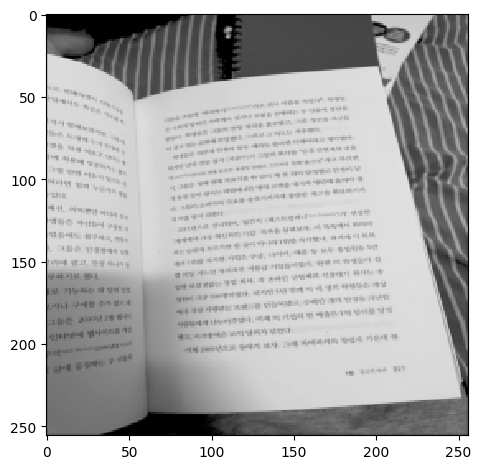

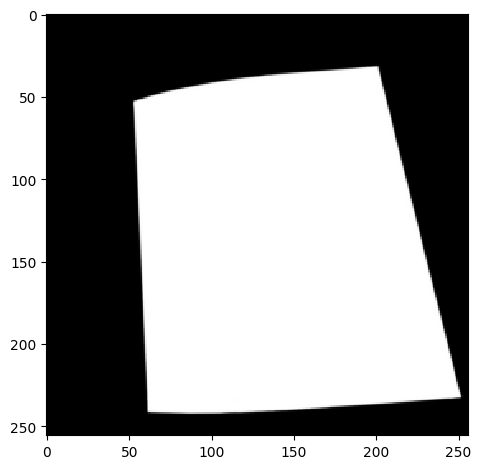

In [95]:
###이미지 확인 #####
ix = random.randint(0, len(train_imgs))
imshow(X_train[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
imshow(np.squeeze(Y_train[ix].reshape(IMG_HEIGHT, IMG_WIDTH)))
plt.show()


In [96]:
# U-Net model 
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255.) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization() (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (p1)
c2 = LeakyReLU()(c2)
c2 = BatchNormalization() (c2)
c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c2)
c2 = LeakyReLU()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (p2)
c3 = LeakyReLU()(c3)
c3 = BatchNormalization() (c3)
c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c3)
c3 = LeakyReLU()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (p3)
c4 = LeakyReLU()(c4)
c4 = BatchNormalization() (c4)
c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c4)
c4 = LeakyReLU()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Conv2D(256, (3, 3), activation='elu',kernel_initializer='he_normal', padding='same') (c5)

#===========================================

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (u6)
c6 = LeakyReLU()(c6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c6)
c6 = LeakyReLU()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (u7)
c7 = LeakyReLU()(c7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c7)
c7 = LeakyReLU()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (u8)
c8 = LeakyReLU()(c8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c8)
c8 = LeakyReLU()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization(momentum=0.9) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

In [97]:
model.compile(optimizer=Nadam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['binary_accuracy','acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  


 lambda_4 (Lambda)              (None, 256, 256, 1)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 256, 256, 16  160         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 256, 256, 16  64         ['conv2d_67[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_68 (Conv2D)             (None, 256, 256, 16  2320        ['batch_normalization_32[0][0]'] 
                                )                                                                 
          

In [100]:
checkpointer = ModelCheckpoint('model-page.h5', verbose=1, save_best_only=True)
reduceLr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=7)

results = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.1, 
                    batch_size=3, 
                    epochs=50,
                    callbacks=[reduceLr, checkpointer])


Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: -122.5904 - binary_accuracy: 0.2048 - acc: 0.2048 
Epoch 1: val_loss improved from inf to -179.66083, saving model to model-page.h5
2/2 [==============================] - 16s 2s/step - loss: -122.5904 - binary_accuracy: 0.2048 - acc: 0.2048 - val_loss: -179.6608 - val_binary_accuracy: 0.0906 - val_acc: 0.0906 - lr: 2.0000e-05
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: -126.3321 - binary_accuracy: 0.2058 - acc: 0.2058
Epoch 2: val_loss improved from -179.66083 to -185.18951, saving model to model-page.h5
2/2 [==============================] - 3s 2s/step - loss: -126.3321 - binary_accuracy: 0.2058 - acc: 0.2058 - val_loss: -185.1895 - val_binary_accuracy: 0.0919 - val_acc: 0.0919 - lr: 2.0000e-05
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: -130.0698 - binary_accuracy: 0.2068 - acc: 0.2068
Epoch 3: val_loss improved from -185.18951 to -190.74358, saving model to model-page.h5
2/2

1/1 [==============================] - 1s 715ms/step
원본 이미지


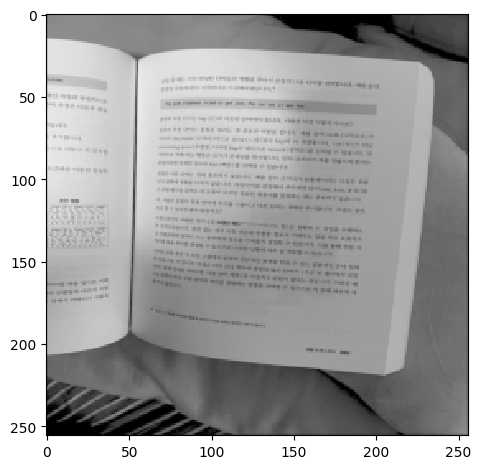

원본 이미지의 세그먼테이션


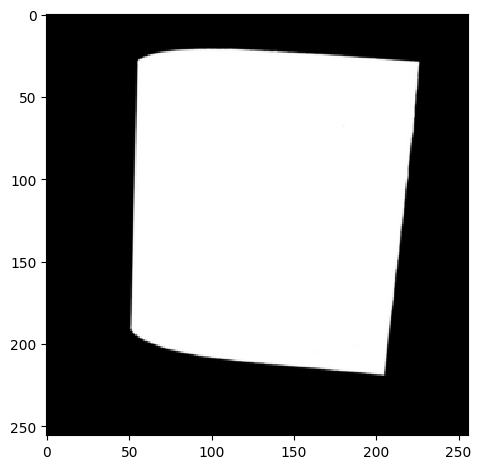

모델의 예측 세그먼테이션


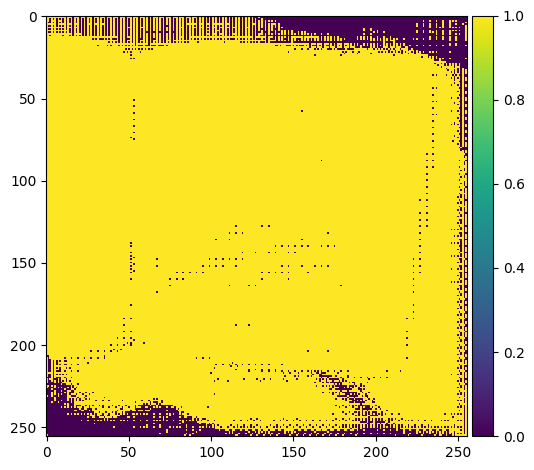

In [102]:
model = load_model('model-page.h5')
preds_test = model.predict(X_test, verbose=1)

#픽셀  평가 결과를 0.5의 임계치로 0 or 255로 변환(평가 결과를 바이너리 이미지로 변환).
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# 임의 결과로 하나를 리턴 받아 표시 
# ix = random.randint(0, len(preds_test_t))
ix = 0
print('원본 이미지')
imshow(X_test[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
print('원본 이미지의 세그먼테이션')
imshow(Y_test[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
print('모델의 예측 세그먼테이션')
imshow(np.squeeze(preds_test_t[ix].reshape(IMG_HEIGHT, IMG_WIDTH)))
plt.show()